## Helper Notebook to Inspect  PNW Dataset





- All waveform data downloaded from [IRIS DMC](https://ds.iris.edu/ds/nodes/dmc/).
- Events and phase information are downloaded from [ANSS/ComCat](https://earthquake.usgs.gov/data/comcat/) using [libcomcat](https://github.com/usgs/libcomcat).

- Please download datasets manually from Goole Drive. See link below.
---
 ##### Yiyu Ni (niyiyu@uw.edu)
 ##### Earth and Space Sciences
 ##### University of Washington

In [1]:
# some modules are not intalled in google colab by default.
pip install obspy scipy

SyntaxError: invalid syntax (1392713144.py, line 2)

In [2]:
# suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import h5py
import obspy
import pandas as pd
import numpy as np

# plotting lib
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

# lib for comcat access
# ... if you work in Google Colab, I haven't find a way to install libcomcat 
# ... through pip. Please skip this part.

# from libcomcat.dataframes import get_phase_dataframe
# from libcomcat.search import get_event_by_id

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
def interactive_plotting(df, index, seconds_before = 3, seconds_after = 3, apply_filter = None, freq = None, freqmax = None, freqmin = None):
    source_id = df.iloc[index]['event_id']
    net = df.iloc[index]['station_network_code']
    sta = df.iloc[index]['station_code']
    loc =  df.iloc[index]['station_location_code']
    cha = df.iloc[index]['trace_channel']
    sample_p = df.iloc[index]['trace_P_arrival_sample']
    sample_s = df.iloc[index]['trace_S_arrival_sample']
    trace_starttime = df.iloc[index]['trace_start_time']
    sample_rate = df.iloc[index]['trace_sampling_rate_hz']
    
    tn = df.iloc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    data = f['/data/%s' % bucket][x, :y, :z]

    stream = obspy.Stream()
    for i in range(3):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.sampling_rate = df.iloc[index]['trace_sampling_rate_hz']
        stream.append(tr)
    
    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)

    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(15001)]
    p_time = [(starttime + dt(seconds = sample_p/sample_rate)) for _ in range(10)]
    s_time = [(starttime + dt(seconds = sample_s/sample_rate)) for _ in range(10)]
    plt.figure(figsize = (12, 10), dpi = 80)
    myFmt = mdates.DateFormatter('%X.%f\n%Y/%m/%d')
    plt.subplots_adjust(hspace = 0.2)
    plt.subplot(2, 1, 1)
    plt.title("%s.%s..%s" % (net, sta, cha), fontsize = 20)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    plt.plot(p_time, np.linspace(-data.max(), data.max(), 10), 
             'r--', label = 'PNSN P Pick', linewidth = 2)
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.legend()
    plt.xlim([p_time[0] - dt(seconds = seconds_before),  
              p_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival


    plt.subplot(2, 1, 2)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    plt.plot(s_time, np.linspace(-data.max(), data.max(), 10), 
             'k--', label = 'PNSN S Pick', linewidth = 2)
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.legend()
    plt.xlim([s_time[0] - dt(seconds = seconds_before),  
              s_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival

## Load the PNW dataset
- waveform (waveforms.hdf5 ~35G): https://drive.google.com/file/d/1Ktee6VV4Nz6I0oo0IjGiW8BX_Zzb7wyE/view?usp=sharing
- metadata (metadata.csv ~19MB): https://drive.google.com/file/d/1TcG1Ey5pxMEZatPXiHufBK0XC_SgO1Bl/view?usp=sharing
- This dataset follows the structure of [seisbench](https://seisbench.readthedocs.io/en/latest/). See [here](https://seisbench.readthedocs.io/en/latest/pages/data_format.html) to learn more about the  file structure.

In [4]:
# be sure to check the location of waveforms and metadata
path_to_data = "/home/niyiyu/.seisbench/datasets/pnw/"

f = h5py.File(path_to_data + "waveforms.hdf5", "r")
df = pd.read_csv(path_to_data + "metadata.csv")
df.insert(0, "index", range(len(df)))
df

,index,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,event_type,source_depth_km,source_magnitude,source_magnitude_type,source_magnitude_uncertainty,...,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,split
0,0,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2002-10-03T01:55:59.530000Z,8097,6733,0.04,0.02,undecidable,NaN,NaN,6.135|3.065|11.766,train
1,1,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2002-10-03T01:55:59.530000Z,7258,6238,0.04,0.01,undecidable,NaN,NaN,nan|nan|23.497,train
2,2,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2002-10-03T01:55:59.530000Z,7037,6113,0.08,0.04,undecidable,NaN,NaN,1.756|3.057|3.551,test
3,3,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,2002-10-03T01:55:59.530000Z,5894,5442,0.04,0.01,negative,NaN,NaN,nan|nan|26.336,train
4,4,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.90,md,0.030,...,2002-09-26T06:59:14.860000Z,8647,6948,0.04,0.01,negative,NaN,NaN,10.881|17.107|2.242,dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156520,156520,uw61722006,2021-04-02T10:48:38.940000Z,45.743,-122.621,earthquake,5.610,1.18,ml,0.105,...,2021-04-02T10:47:48.940000Z,6527,5836,0.06,0.06,negative,impulsive,impulsive,-2.635|0.701|-4.224,test
156521,156521,uw61722006,2021-04-02T10:48:38.940000Z,45.743,-122.621,earthquake,5.610,1.18,ml,0.105,...,2021-04-02T10:47:48.940000Z,6622,5896,0.15,0.06,negative,emergent,impulsive,13.674|11.735|10.436,train
156522,156522,uw61722006,2021-04-02T10:48:38.940000Z,45.743,-122.621,earthquake,5.610,1.18,ml,0.105,...,2021-04-02T10:47:48.940000Z,6923,6076,0.15,0.15,undecidable,emergent,emergent,-0.268|4.398|7.123,train
156523,156523,uw61722006,2021-04-02T10:48:38.940000Z,45.743,-122.621,earthquake,5.610,1.18,ml,0.105,...,2021-04-02T10:47:48.940000Z,6870,6049,0.15,0.15,undecidable,emergent,emergent,14.683|12.908|0.180,train


In [5]:
df.keys()

Index(['index', 'event_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'event_type', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type',
       'source_magnitude_uncertainty', 'source_depth_uncertainty_km',
       'source_horizontal_uncertainty_km', 'station_network_code',
       'trace_channel', 'station_code', 'station_location_code',
       'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m',
       'trace_name', 'trace_sampling_rate_hz', 'trace_start_time',
       'trace_S_arrival_sample', 'trace_P_arrival_sample',
       'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s',
       'trace_P_polarity', 'trace_S_onset', 'trace_P_onset', 'trace_snr_db',
       'split'],
      dtype='object')

## Do some stream selection only if necessary

In [6]:
df_filt = df

# df_filt = df_filt[df_filt['source_id'] == 'uw61631152']      # select a source id
df_filt = df_filt[df_filt['trace_channel'] == 'EH']          # select filter out magnitude
# df_filt = df_filt[df_filt['station_network_code'] == 'UW']   # select network code
# df_filt = df_filt[df_filt['station_code'] == 'VLL']          # select station code

index = df_filt.index

## Specify an index by looking at the "index" column of filtered dataframe

In [7]:
# specify a index:
index = 156537

# ... or randomly look at all data set:
# index = np.random.randint(103957)

df.iloc[index]

IndexError: single positional indexer is out-of-bounds

## Interactive plotting of stream
**Note that interactive plotting is not available at Google Colab**

In [10]:
i = 0

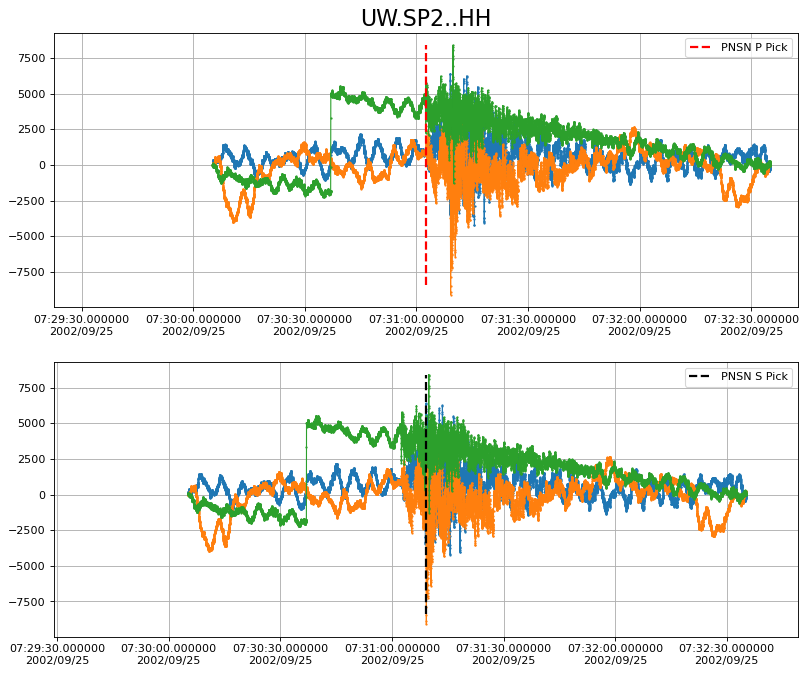

In [22]:
# %matplotlib notebook
i += 1

# index = np.random.randint(i)

interactive_plotting(df, i, seconds_before = 100, seconds_after = 100)

## Use ComCat Python interface to check the arrivals from ANSS

In [ ]:
source_id = df.iloc[index]['source_id']
detail = get_event_by_id(source_id, includesuperseded=False)
df_cc = get_phase_dataframe(detail, catalog='uw')
df_cc[df_cc['Channel'].str.contains(df.iloc[index]['station_code'])]

NameError: ignored